In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
from keras.models import load_model
import tensorflow as tf
from keras import optimizers
import keras
import segmentation_models as sm

import metric
from architecture import create_model, create_callbacks


BACKUP_MODEL_PATH = "./../Models/backup.h5"
seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 4

ROOT = "./../Data/Hannover/"
TRAIN_DIR = "_Train512/"

Segmentation Models: using `keras` framework.


In [2]:
import get_data_generators

no_augmentation = {
"rotation_range": 0,
"width_shift_range": 0,
"height_shift_range": 0,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "False",
"vertical_flip": "False",
"validation_split": 0.08
}

augmentation = {
"rotation_range": 90,
"width_shift_range": 0.2,
"height_shift_range": 0.2,
"fill_mode": "constant",
"cval": 0,
"horizontal_flip": "True",
"vertical_flip": "True",
"validation_split": 0.08
}

augmentation = no_augmentation
train_gen, val_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), ROOT + TRAIN_DIR + "Images", ROOT + TRAIN_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed)

Found 3607 images belonging to 1 classes.
Found 313 images belonging to 1 classes.
Found 3607 images belonging to 1 classes.
Found 313 images belonging to 1 classes.


In [3]:
opt = keras.optimizers.Adam(LEARNING_RATE)
callbacks = create_callbacks(BACKUP_MODEL_PATH)

In [5]:
# """Load Model backup to resume training after crash or break or for pretraining"""
# model = load_model(BACKUP_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.5), "f1-score":sm.metrics.FScore()})

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=5e-06>


In [4]:
PRETRAINED_MODEL_PATH = "./../Models/Roads/road_mapper_scratch_x512_Combined_Train18598_Val1617_Test5079_No-Aug_IoU6065_f7516.h5"

model = load_model(PRETRAINED_MODEL_PATH, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore()})

first_half = ["conv2d","conv2d_1","conv2d_2","conv2d_3","conv2d_4","conv2d_5","conv2d_6","conv2d_7","conv2d_8"]
second_half = ["conv2d_9","conv2d_10","conv2d_11","conv2d_12","conv2d_13","conv2d_14","conv2d_15","conv2d_16","conv2d_17"]

for layer in model.layers:
      if layer.name in second_half:
            layer.trainable = False
      if layer.name in ["dropout", "dropout_1", "dropout_2", "dropout_3", "dropout_4", "dropout_5", "dropout_6", "dropout_7", "dropout_8"]:
            layer.rate = 2*layer.rate

#print(model.layers)
met = model.metrics[1:] #+ [metric.quality()] # [1:] to not include loss

model.compile(optimizer=opt, loss=model.loss, metrics= met, run_eagerly=True)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

history = model.fit(train_gen.data,  validation_data=val_gen.data, steps_per_epoch=train_gen.samplesPerBatch, validation_steps=val_gen.samplesPerBatch, callbacks=list(callbacks), epochs=EPOCHS, verbose=1) #,

Num GPUs Available:  1
Epoch 1/100
902/901 [==============================] - ETA: 0s - loss: 0.7235 - iou_score: 0.1651 - f1-score: 0.2764
Epoch 1: val_loss improved from inf to 0.66861, saving model to ./../Models\backup.h5
901/901 [==============================] - 199s 216ms/step - loss: 0.7235 - iou_score: 0.1651 - f1-score: 0.2764 - val_loss: 0.6686 - val_iou_score: 0.2063 - val_f1-score: 0.3323 - lr: 1.0000e-04
Epoch 2/100
902/901 [==============================] - ETA: 0s - loss: 0.6625 - iou_score: 0.2088 - f1-score: 0.3376
Epoch 2: val_loss improved from 0.66861 to 0.64953, saving model to ./../Models\backup.h5
901/901 [==============================] - 192s 213ms/step - loss: 0.6625 - iou_score: 0.2088 - f1-score: 0.3376 - val_loss: 0.6495 - val_iou_score: 0.2187 - val_f1-score: 0.3476 - lr: 1.0000e-04
Epoch 3/100
902/901 [==============================] - ETA: 0s - loss: 0.6399 - iou_score: 0.2260 - f1-score: 0.3601
Epoch 3: val_loss improved from 0.64953 to 0.62233, saving

In [7]:
import datetime

print("Time of saving model:", datetime.datetime.now())

model_path = "./../Models/Binary/512/bike_mapper_pre-train-freeze-right-lr1e-4_double-dropout_Train3607_Val313_Test980_No-Aug.h5"
model.save(model_path)

Time of saving model: 2022-10-26 10:53:53.951043


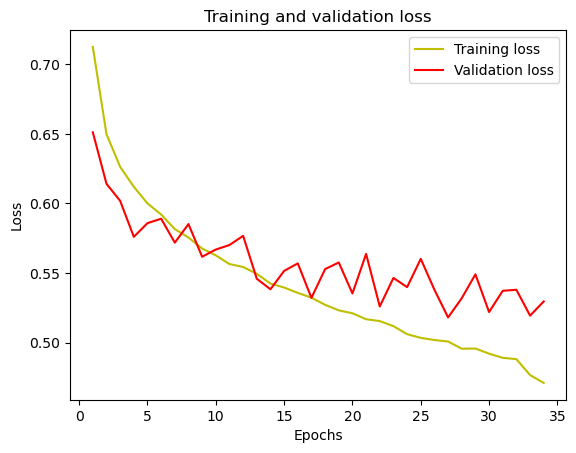

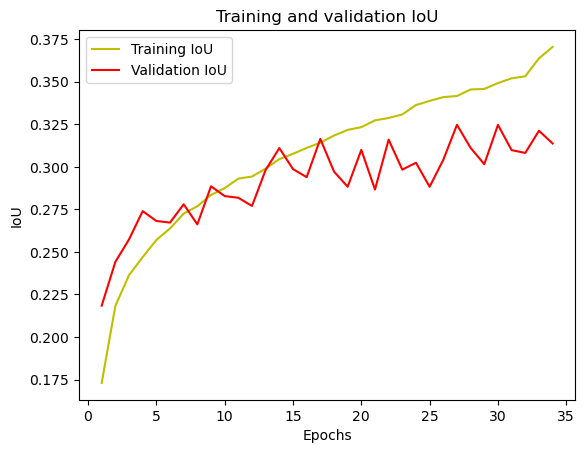

In [8]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(model_path[:-3] + "__loss.png")

plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig(model_path[:-3] + "__iou.png")
plt.show()

In [4]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
# def iou_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
#   union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
#   iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
#
#   return iou
#
# def dice_coef(y_true, y_pred, smooth = 1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#
# def soft_dice_loss(y_true, y_pred):
#     return 1-dice_coef(y_true, y_pred)